<a href="https://colab.research.google.com/github/SirichaiKhomleart/cognitive-systems-for-health-technology-applications/blob/master/Supplementary_for_Case_3_Patient_Drug_Review_with_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supplementary for Case 3 - Patient Drug Review with Full Dataset
Mr.Sirichai Khomleart<br>
Mr.Puttiwat Wanna<br>
Last edited: 17.04.2018<br>
Cognitive Systems for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

## Objectives

<br>The purpose of this notebook is to show different model techniques comparison for predicting how useful of the drug based on review from pateints/users. 

<br>We believed that increase data size will be result in solving overfitting problem we faced in case 3.

<br>The aim of this Notebook is to show how to use keras embedding layers together with LSTM, GRU and Conv1D layers to classify review of Levenorgestrel drug. 

## Data preparation

In [0]:
# Read basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['300_test', '300_train', 'drugsComTest_raw.csv', 'drugsComTrain_raw.csv', 'kuc-hackathon-winter-2018.zip', 'newTrainLabels.csv', 'retinopathy_solution.csv']


In [0]:
%pylab inline
import time
from time import localtime, strftime
import os
import cv2 #opencv
import pickle
import warnings
warnings.filterwarnings("ignore") #Disable warnings
import pandas as pd
import numpy as np
from numpy import corrcoef #Calculate correlation coefficient
from numpy import array
import matplotlib.pyplot as plt #Visual graphs
import pandas as pd

#sklearn libraries
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize #normalize dataset
from sklearn.utils import shuffle #shuffle dataset
from sklearn.metrics import roc_curve #ROC Curves
from sklearn.metrics import auc #AUC 
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report #For Analysis
from sklearn.metrics import accuracy_score, roc_curve #For Calculation Scores

#keras libraries
import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import backend as K
from keras import models, layers
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import Model, load_model
from keras import optimizers
from keras.layers import Dense, Activation
from keras.preprocessing.image import ImageDataGenerator #For Image Augmentation
from keras.callbacks import ModelCheckpoint
from keras.applications import Xception #Pretrained Xception Model
from keras.applications import VGG16 #Pretrain VGG16 Model
from keras.applications import InceptionV3 #Pretrain InceptionV3 Model
from keras.applications import InceptionResNetV2 #Pretrain InceptionResNetV2

import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Read the training data
data = pd.read_csv('../input/drugsComTrain_raw.csv')

In [0]:
# Show the head of the data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [0]:
# Create labels based on the original article: Grässer et al. (2018)
r = data['rating']
labels = -1*(r <= 4) + 1*(r >= 7)
# Add the label column to the data
data['label'] = labels
# Check the new data
data.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [0]:
# Check ratings to labels conversion
import matplotlib.pyplot as plt
data.plot(x = 'rating', y = 'label', kind = 'scatter')
plt.show()

<Figure size 640x480 with 1 Axes>

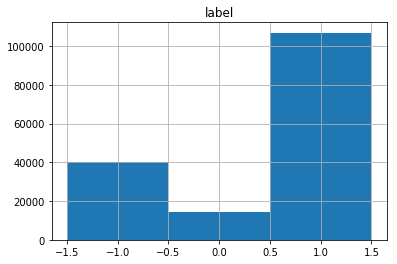

In [0]:
# Plot distribution of labels
data.hist(column = 'label', bins = np.arange(-1, 3), align = 'left');

## Convert reviews to padded sequences

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# # Read a part of the reviews and create training sequences (x_train)
# samples = data['review'].iloc[:10000]
# tokenizer = Tokenizer(num_words = 1000)
# tokenizer.fit_on_texts(samples)
# sequences = tokenizer.texts_to_sequences(samples)
# x_train = pad_sequences(sequences, maxlen = 500)

samples = data['review']
tokenizer = Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 1000)

Using TensorFlow backend.


In [0]:
data

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,-1
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,7-Mar-17,5,-1
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32,1
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,9-Aug-16,11,-1
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,1


## Convert labels to one-hot-categories

In [0]:
from keras.utils import to_categorical

# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:161297], num_classes = 3)

## Check the shapes

In [0]:
# Check the training and label sets
x_train.shape, one_hot_labels.shape

((161297, 1000), (161297, 3))

## Helper functions

In [0]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [0]:
# Similarly create a function for model training, for demonstration purposes we use constant values
def train_model(model_name,model, x, y, e = 10, bs = 32, v = 1, vs = 0.25):
   
    
    # Save the model giving best validation loss
    cb = ModelCheckpoint( 'best_'+model_name+'.h5', 
                          monitor = 'val_loss', 
                          verbose = v, 
                          save_best_only = True)

    # Start timing
    start = time.time()

    # Training
    print('Training the model: '+model_name)
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs,callbacks = [cb])
    stop = time.time()
    etime = stop - start
    print('Done. Elapsed time {:.0f} seconds for {:} epochs, average {:.1f} seconds/epoch.'.format(etime, e, etime/e))

    
    model.save('save_'+model_name+'.h5')

    # Save the history
    import pickle
    with open('history_'+model_name, 'wb') as file_pi:
        pickle.dump(h.history, file_pi)
    return h

## Example 1 - Embedding and Flatten

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# First model: Embedding layer -> Flatten -> Dense classifier
# m0 = Sequential()
# m0.add(Embedding(1000, 64, input_length = 500)) # 1000 = num_words, 64 = Embedding layers, 500 = sequence length
# m0.add(Flatten())
# m0.add(Dense(32, activation = 'relu'))
# m0.add(Dense(3, activation = 'softmax'))
# m0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m0.summary()

m0 = Sequential()
m0.add(Embedding(2000, 64, input_length = 1000)) # 1000 = num_words, 64 = Embedding layers, 500 = sequence length
m0.add(Flatten())
m0.add(Dense(32, activation = 'relu'))
m0.add(Dense(3, activation = 'softmax'))
m0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 64)          128000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,176,131
Trainable params: 2,176,131
Non-trainable params: 0
_________________________________________________________________


Training the model: 1
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 44s 362us/step - loss: 0.6200 - acc: 0.7660 - val_loss: 0.5820 - val_acc: 0.7823

Epoch 00001: val_loss improved from inf to 0.58204, saving model to best_1.h5
Epoch 2/10
120972/120972 [==============================] - 44s 361us/step - loss: 0.5247 - acc: 0.8031 - val_loss: 0.6069 - val_acc: 0.7830

Epoch 00002: val_loss did not improve from 0.58204
Epoch 3/10
120972/120972 [==============================] - 44s 362us/step - loss: 0.4542 - acc: 0.8311 - val_loss: 0.6735 - val_acc: 0.7554

Epoch 00003: val_loss did not improve from 0.58204
Epoch 4/10
120972/120972 [==============================] - 44s 366us/step - loss: 0.3847 - acc: 0.8592 - val_loss: 0.7114 - val_acc: 0.6931

Epoch 00004: val_loss did not improve from 0.58204
Epoch 5/10
120972/120972 [==============================] - 43s 357us/step - loss: 0.3272 - acc: 0.8813 - val_loss: 0.6515 - val

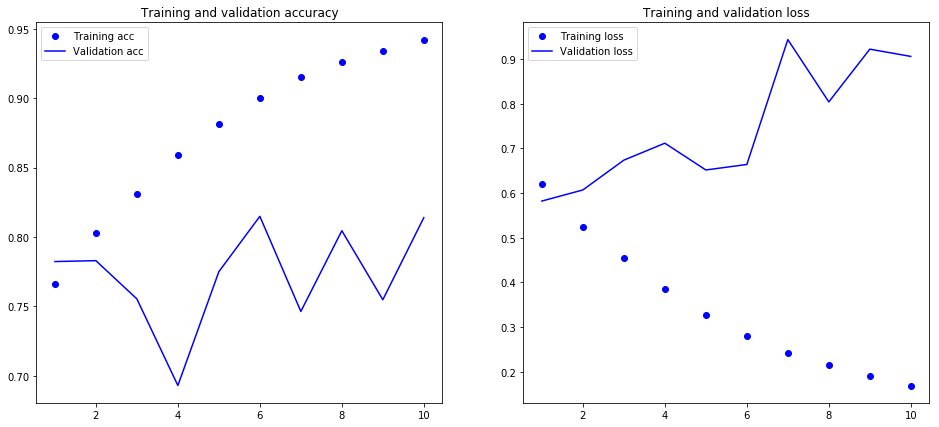

In [0]:
# Train the first model and plot the history
h0 = train_model('1',m0, x_train, one_hot_labels)
plot_history(h0)

In [0]:
del m0
del h0
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 2 - Embedding and LSTM

In [0]:
from keras.layers import LSTM

# Second model: Embedding -> LSTM -> Dense classifier
# m1 = Sequential()
# m1.add(Embedding(1000, 8, input_length = 500))
# m1.add(LSTM(8))
# m1.add(Dense(3, activation = 'softmax'))
# m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m1.summary()

m1 = Sequential()
m1.add(Embedding(2000, 8, input_length = 1000))
m1.add(LSTM(8))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           16000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 16,571
Trainable params: 16,571
Non-trainable params: 0
_________________________________________________________________


Training the model: 2
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 6917s 57ms/step - loss: 0.6452 - acc: 0.7500 - val_loss: 0.5871 - val_acc: 0.7790

Epoch 00001: val_loss improved from inf to 0.58711, saving model to best_2.h5
Epoch 2/10
120972/120972 [==============================] - 6996s 58ms/step - loss: 0.5755 - acc: 0.7849 - val_loss: 0.5852 - val_acc: 0.7755

Epoch 00002: val_loss improved from 0.58711 to 0.58518, saving model to best_2.h5
Epoch 3/10
120972/120972 [==============================] - 6926s 57ms/step - loss: 0.5630 - acc: 0.7897 - val_loss: 0.5951 - val_acc: 0.7721

Epoch 00003: val_loss did not improve from 0.58518
Epoch 4/10
120972/120972 [==============================] - 6923s 57ms/step - loss: 0.5556 - acc: 0.7937 - val_loss: 0.5729 - val_acc: 0.7900

Epoch 00004: val_loss improved from 0.58518 to 0.57289, saving model to best_2.h5
Epoch 5/10
120972/120972 [==============================] - 69

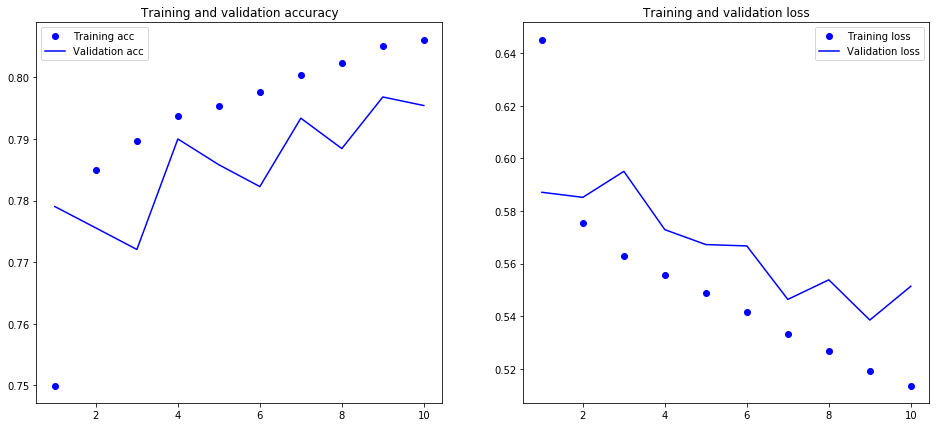

In [0]:
# Train the second model and plot the history
h1 = train_model('2',m1, x_train, one_hot_labels)
plot_history(h1)

In [0]:
del m1
del h1
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 3 - Embedding and GRU

In [0]:
from keras.layers import GRU

# Third model: Embedding -> GRU -> Dense classifier
# m2 = Sequential()
# m2.add(Embedding(1000, 8, input_length = 500))
# m2.add(GRU(8))
# m2.add(Dense(3, activation = 'softmax'))
# m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m2.summary()

m2 = Sequential()
m2.add(Embedding(2000, 8, input_length = 1000))
m2.add(GRU(8))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           16000     
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 16,435
Trainable params: 16,435
Non-trainable params: 0
_________________________________________________________________


Training the model: 3
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 5561s 46ms/step - loss: 0.6662 - acc: 0.7411 - val_loss: 0.5970 - val_acc: 0.7728

Epoch 00001: val_loss improved from inf to 0.59703, saving model to best_3.h5
Epoch 2/10
120972/120972 [==============================] - 5499s 45ms/step - loss: 0.5697 - acc: 0.7890 - val_loss: 0.5891 - val_acc: 0.7817

Epoch 00002: val_loss improved from 0.59703 to 0.58906, saving model to best_3.h5
Epoch 3/10
120972/120972 [==============================] - 5484s 45ms/step - loss: 0.5489 - acc: 0.7976 - val_loss: 0.5607 - val_acc: 0.7926

Epoch 00003: val_loss improved from 0.58906 to 0.56071, saving model to best_3.h5
Epoch 4/10
120972/120972 [==============================] - 5487s 45ms/step - loss: 0.5380 - acc: 0.8012 - val_loss: 0.5512 - val_acc: 0.7950

Epoch 00004: val_loss improved from 0.56071 to 0.55124, saving model to best_3.h5
Epoch 5/10
120972/120972 [=====

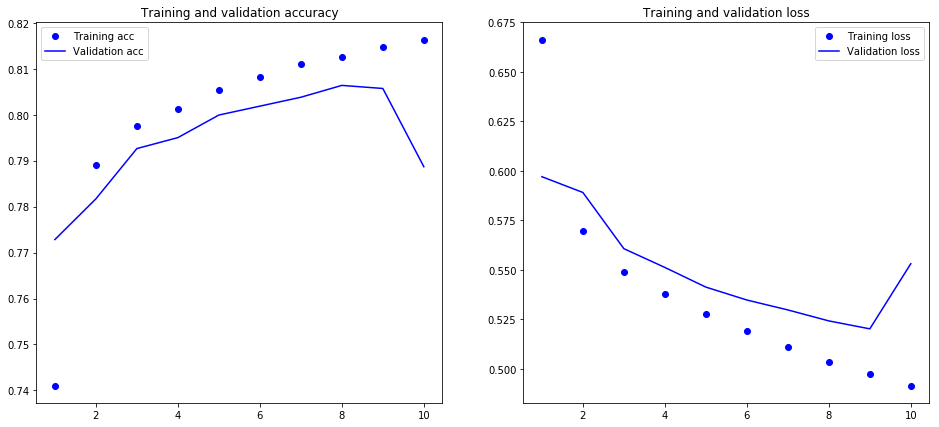

In [0]:
# Train the third model and plot the history
h2 = train_model('3',m2, x_train, one_hot_labels)
plot_history(h2)

In [0]:
del m2
del h2
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 4 - Embedding and GRU with dropout

In [0]:
# Fourth model: Embedding -> GRU with dropouts -> Dense classifier
# m3 = Sequential()
# m3.add(Embedding(1000, 8, input_length = 500))
# m3.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
# m3.add(Dense(3, activation = 'softmax'))
# m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m3.summary()
m3 = Sequential()
m3.add(Embedding(2000, 8, input_length = 1000))
m3.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           16000     
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 16,435
Trainable params: 16,435
Non-trainable params: 0
_________________________________________________________________


Training the model: 4
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 6231s 52ms/step - loss: 0.7170 - acc: 0.7179 - val_loss: 0.6350 - val_acc: 0.7560

Epoch 00001: val_loss improved from inf to 0.63500, saving model to best_4.h5
Epoch 2/10
120972/120972 [==============================] - 6237s 52ms/step - loss: 0.6167 - acc: 0.7685 - val_loss: 0.5800 - val_acc: 0.7838

Epoch 00002: val_loss improved from 0.63500 to 0.57999, saving model to best_4.h5
Epoch 3/10
120972/120972 [==============================] - 6252s 52ms/step - loss: 0.5861 - acc: 0.7827 - val_loss: 0.5709 - val_acc: 0.7875

Epoch 00003: val_loss improved from 0.57999 to 0.57087, saving model to best_4.h5
Epoch 4/10
120972/120972 [==============================] - 6443s 53ms/step - loss: 0.5732 - acc: 0.7878 - val_loss: 0.5626 - val_acc: 0.7899

Epoch 00004: val_loss improved from 0.57087 to 0.56258, saving model to best_4.h5
Epoch 5/10
120972/120972 [=====

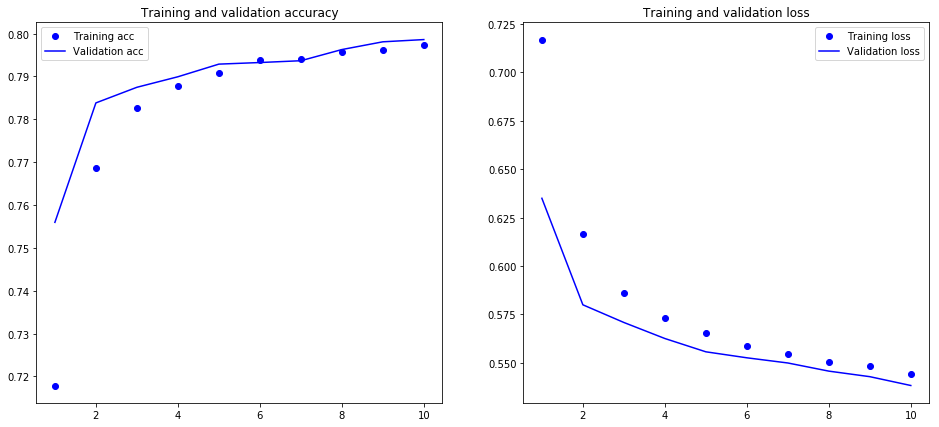

In [0]:
# Train and plot the history
h3 = train_model('4',m3, x_train, one_hot_labels)
plot_history(h3)

In [0]:
del m3
del h3
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 5 - Embedding and stack of GRUs

In [0]:
# Fifth model: Embedding -> Stack of GRU layers -> Dense classifier
# m4 = Sequential()
# m4.add(Embedding(1000, 8, input_length = 500))
# m4.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True))
# m4.add(GRU(8, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.5))
# m4.add(Dense(3, activation = 'softmax'))
# m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m4.summary()

m4 = Sequential()
m4.add(Embedding(2000, 8, input_length = 1000))
m4.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True))
m4.add(GRU(8, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.5))
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 8)           16000     
_________________________________________________________________
gru_1 (GRU)                  (None, 1000, 8)           408       
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 16,843
Trainable params: 16,843
Non-trainable params: 0
_________________________________________________________________


Training the model: 5
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 12416s 103ms/step - loss: 0.7375 - acc: 0.7065 - val_loss: 0.6645 - val_acc: 0.7409

Epoch 00001: val_loss improved from inf to 0.66454, saving model to best_5.h5
Epoch 2/10
120972/120972 [==============================] - 12910s 107ms/step - loss: 0.6443 - acc: 0.7575 - val_loss: 0.5977 - val_acc: 0.7748

Epoch 00002: val_loss improved from 0.66454 to 0.59769, saving model to best_5.h5
Epoch 3/10
120972/120972 [==============================] - 12958s 107ms/step - loss: 0.6024 - acc: 0.7765 - val_loss: 0.5776 - val_acc: 0.7839

Epoch 00003: val_loss improved from 0.59769 to 0.57763, saving model to best_5.h5
Epoch 4/10
120972/120972 [==============================] - 13471s 111ms/step - loss: 0.5819 - acc: 0.7858 - val_loss: 0.5677 - val_acc: 0.7896

Epoch 00004: val_loss improved from 0.57763 to 0.56767, saving model to best_5.h5
Epoch 5/10
120972/12097

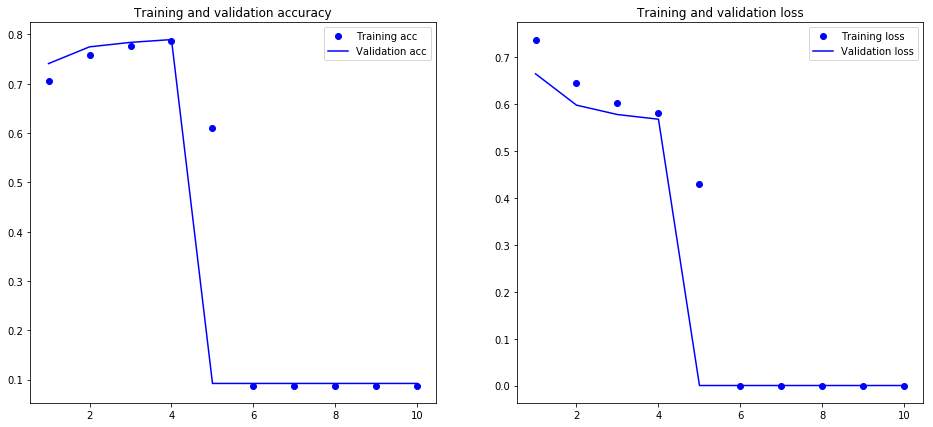

In [0]:
# Train and plot the history
h4 = train_model('5',m4, x_train, one_hot_labels)
plot_history(h4)

In [0]:
del m4
del h4
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 6 - Embedding and Conv1D

In [0]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Sixth model: Embedding -> Conv1D & MaxPooling1D -> Dense classifier
# m5 = Sequential()
# m5.add(Embedding(1000, 32, input_length = 500))
# m5.add(Conv1D(32, 7, activation = 'relu'))
# m5.add(MaxPooling1D(5))
# m5.add(Conv1D(32, 7, activation = 'relu'))
# m5.add(GlobalMaxPooling1D())
# m5.add(Dense(3, activation = 'softmax'))
# m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m5.summary()

m5 = Sequential()
m5.add(Embedding(2000, 32, input_length = 1000))
m5.add(Conv1D(32, 7, activation = 'relu'))
m5.add(MaxPooling1D(5))
m5.add(Conv1D(32, 7, activation = 'relu'))
m5.add(GlobalMaxPooling1D())
m5.add(Dense(3, activation = 'softmax'))
m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 994, 32)           7200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 198, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 32)           7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 78,499
Trainable params: 78,499
Non-trainable params: 0
_________________________________________________________________


Training the model: 6
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 41s 337us/step - loss: 0.6330 - acc: 0.7547 - val_loss: 0.5701 - val_acc: 0.7823

Epoch 00001: val_loss improved from inf to 0.57015, saving model to best_6.h5
Epoch 2/10
120972/120972 [==============================] - 37s 307us/step - loss: 0.5380 - acc: 0.7943 - val_loss: 0.5373 - val_acc: 0.7946

Epoch 00002: val_loss improved from 0.57015 to 0.53733, saving model to best_6.h5
Epoch 3/10
120972/120972 [==============================] - 37s 308us/step - loss: 0.4932 - acc: 0.8144 - val_loss: 0.5197 - val_acc: 0.8018

Epoch 00003: val_loss improved from 0.53733 to 0.51971, saving model to best_6.h5
Epoch 4/10
120972/120972 [==============================] - 37s 307us/step - loss: 0.4533 - acc: 0.8294 - val_loss: 0.5149 - val_acc: 0.8071

Epoch 00004: val_loss improved from 0.51971 to 0.51494, saving model to best_6.h5
Epoch 5/10
120972/120972 [=========

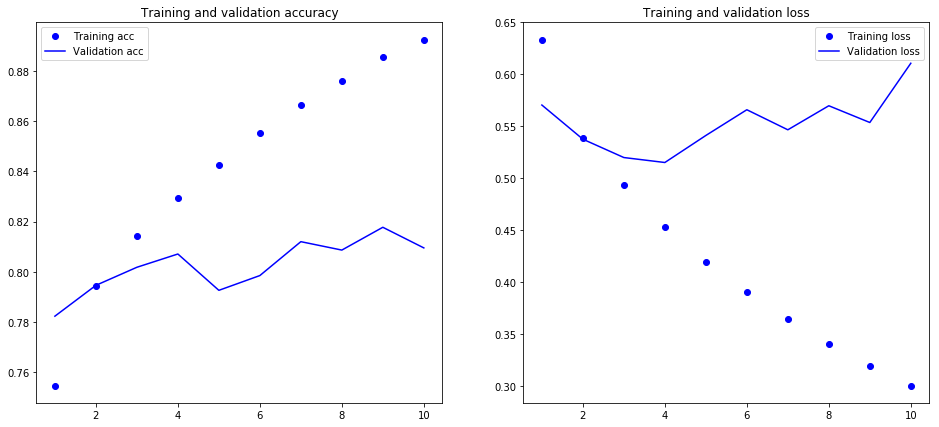

In [0]:
# Train and plot the history
h5 = train_model('6',m5, x_train, one_hot_labels)
plot_history(h5)

In [0]:
del m5
del h5
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()

## Example 7 - Embedding and mixed Conv1D and GRU

In [0]:
# Seventh model: Embedding -> 2 x Conv1D + MaxPooling -> GRU -> Dense
# m6 = Sequential()
# m6.add(Embedding(1000, 32, input_length = 500))
# m6.add(Conv1D(32, 5, activation = 'relu'))
# m6.add(MaxPooling1D(5))
# m6.add(Conv1D(32, 7, activation = 'relu'))
# m6.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5))
# m6.add(Dense(3, activation = 'softmax'))
# m6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
# m6.summary()
m6 = Sequential()
m6.add(Embedding(2000, 32, input_length = 1000))
m6.add(Conv1D(32, 5, activation = 'relu'))
m6.add(MaxPooling1D(5))
m6.add(Conv1D(32, 7, activation = 'relu'))
m6.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 32)          64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 32)           5152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 193, 32)           7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 77,363
Trainable params: 77,363
Non-trainable params: 0
_________________________________________________________________


Training the model: 7
Train on 120972 samples, validate on 40325 samples
Epoch 1/10
120972/120972 [==============================] - 1263s 10ms/step - loss: 0.6135 - acc: 0.7672 - val_loss: 0.5602 - val_acc: 0.7901

Epoch 00001: val_loss improved from inf to 0.56024, saving model to best_7.h5
Epoch 2/10
120972/120972 [==============================] - 1290s 11ms/step - loss: 0.5203 - acc: 0.8073 - val_loss: 0.5139 - val_acc: 0.8094

Epoch 00002: val_loss improved from 0.56024 to 0.51395, saving model to best_7.h5
Epoch 3/10
120972/120972 [==============================] - 1308s 11ms/step - loss: 0.4832 - acc: 0.8206 - val_loss: 0.5251 - val_acc: 0.8070

Epoch 00003: val_loss did not improve from 0.51395
Epoch 4/10
120972/120972 [==============================] - 1307s 11ms/step - loss: 0.4557 - acc: 0.8318 - val_loss: 0.4923 - val_acc: 0.8157

Epoch 00004: val_loss improved from 0.51395 to 0.49228, saving model to best_7.h5
Epoch 5/10
120972/120972 [==============================] - 13

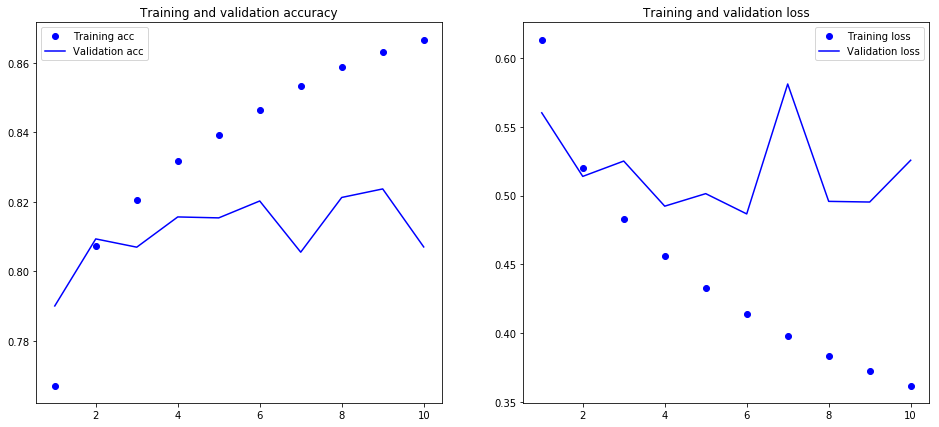

In [0]:
# Train and plot the history
h6 = train_model('7',m6, x_train, one_hot_labels)
plot_history(h6)

In [0]:
del m6
del h6
from keras import backend as K 
tf.reset_default_graph() # for being sure
K.clear_session()